In [135]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from functools import partial
from collections import deque
%matplotlib inline
from scipy.integrate import solve_ivp
import sympy as sym
sym.init_printing()
import tensorflow as tf

### Single Pendulum

In [50]:
# Note: m = 1, l = 1, g = 9.81 for all pendulums

class Small_Pendulum:
    g=9.81 # gravitational acceleration
    def __init__(self, initial_theta=0, initial_omega=0, time = 10, dt = 0.01):

        # small pendulum equation: theta'' + g/l * theta = 0
        
        sol = solve_ivp(lambda t, y : [y[1], -Small_Pendulum.g * y[0]], 
                        [0, time], 
                        [initial_theta, initial_omega], 
                        t_eval=np.arange(0, time, dt))
        
        self.thetas = sol.y[0]
        
        self.x = np.sin(self.thetas) # x position
        self.y = -np.cos(self.thetas) # y position


class Pendulum:
    g = 9.81 # gravitational acceleration
    def __init__(self, initial_theta=0, initial_omega=0, time = 10, dt = 0.01):

        # pendulum equation: theta'' + g/l * sin(theta) = 0
        sol = solve_ivp(lambda t, y : [y[1], -Pendulum.g * np.sin(y[0])], 
                        [0, time], 
                        [initial_theta, initial_omega], 
                        t_eval=np.arange(0, time, dt))

        self.thetas = sol.y[0]

        self.x = np.sin(self.thetas) # x position
        self.y = -np.cos(self.thetas) # y position


In [51]:
initial_theta = np.pi+0.3
pendulum = Pendulum(initial_theta=initial_theta, time = 20)
small_pendulum = Small_Pendulum(initial_theta=initial_theta, time = 20)

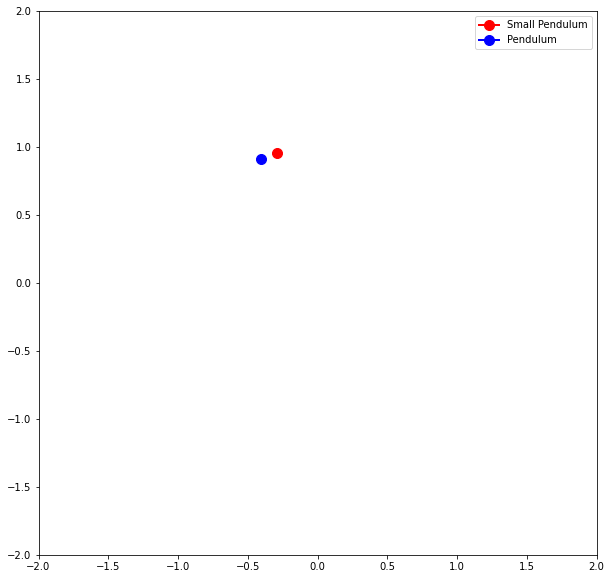

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
 

axes.set_ylim(-2,2)
axes.set_xlim(-2,2)

line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
line2, = axes.plot([], [], lw = 2, color = 'blue', marker = 'o', markersize = 10)

axes.legend([line1, line2], ['Small Pendulum', 'Pendulum'])

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,


# animation function
def animate(i):
    x0, y0 = small_pendulum.x[i], small_pendulum.y[i]
    x1, y1 = pendulum.x[i], pendulum.y[i]
    # x, y values to be plotted
    line1.set_data(x0, y0)
    line2.set_data(x1, y1)
    return line1, line2,
 
# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 400,
                            interval = 20,
                            blit = True)
anim.save('pend.mp4', writer = 'ffmpeg', fps = 30)

### Double Pendulum

System Set-up

In [123]:
g, t = sym.symbols('g t')
# We take m = 1, l = 1 for both pendulums for simplicity

In [124]:
theta1 = sym.Function('theta1')(t)
theta2 = sym.Function('theta2')(t)
dtheta1_dt = sym.diff(theta1, t)
dtheta2_dt = sym.diff(theta2, t)
ddtheta1_dtdt = sym.diff(dtheta1_dt, t)
ddtheta2_dtdt = sym.diff(dtheta2_dt, t)

In [125]:
x1 = sym.sin(theta1)
y1 = -sym.cos(theta1)
x2 = x1 + sym.sin(theta2)
y2 = y1 - sym.cos(theta2)

Lagrangian

In [126]:
T = sym.Rational(1,2) * (sym.diff(x1, t)**2 + sym.diff(y1, t)**2 + sym.diff(x2, t)**2 + sym.diff(y2, t)**2)
U = g * (y1 + y2)
L = (T - U).simplify()

Euler-Lagrange Equations

In [127]:
del_L_t1 = sym.diff(L, theta1)
del_L_t2 = sym.diff(L, theta2)
d_del_L_dt1 = sym.diff(sym.diff(L, dtheta1_dt), t).simplify()
d_del_L_dt2 = sym.diff(sym.diff(L, dtheta2_dt), t).simplify()

In [128]:
L_1 = sym.Eq(del_L_t1, d_del_L_dt1)
L_2 = sym.Eq(del_L_t2, d_del_L_dt2)

Solve for second derivatives

In [129]:
sol = sym.solve([L_1, L_2], [ddtheta1_dtdt, ddtheta2_dtdt])
ddtheta1_dtdt = sol[ddtheta1_dtdt]
ddtheta2_dtdt = sol[ddtheta2_dtdt]

Put in form of a system of first order ODEs:
$$ \underline{\dot{z}} = f(t,\underline{z})$$

$$ \underline{z} = [\theta_1, \dot{\theta}_1,\theta_2, \dot{\theta}_2] \implies \underline{\dot{z}} = [\dot{\theta}_1, \ddot{\theta}_1,\dot{\theta}_2, \ddot{\theta}_2]$$

In [130]:
# Turn the symbolic equations into functions
func_dtheta1_dt = sym.lambdify(dtheta1_dt, dtheta1_dt)
func_ddtheta1_dtdt = sym.lambdify((theta1, theta2, dtheta1_dt, dtheta2_dt, g), ddtheta1_dtdt)
func_dtheta2_dt = sym.lambdify(dtheta2_dt, dtheta2_dt)
func_ddtheta2_dtdt = sym.lambdify((theta1, theta2, dtheta1_dt, dtheta2_dt, g), ddtheta2_dtdt)

In [131]:
# Define the state vector
def dbl_pendulum_state(t, th, g=9.81):
    th1, dth1, th2, dth2 = th
    return np.array([dth1, func_ddtheta1_dtdt(th1, th2, dth1, dth2, g), dth2,  func_ddtheta2_dtdt(th1, th2, dth1, dth2, g)])

In [132]:
# Solve the ODE: Initial condition vector is [theta1, dtheta1, theta2, dtheta2]
double_pendulum = solve_ivp(dbl_pendulum_state, 
                            [0, 30], 
                            [np.pi+0.3,  2, np.pi+0.2, -1], 
                            t_eval=np.arange(0, 30, 0.01))

In [133]:
# Get the x and y positions of the pendulums
th1 = double_pendulum.y[0]
dth1 = double_pendulum.y[1]
th2 = double_pendulum.y[2]
dth2 = double_pendulum.y[3]
x1 = np.sin(th1)
y1 = -np.cos(th1)
x2 = x1 + np.sin(th2)
y2 = y1 - np.cos(th2)

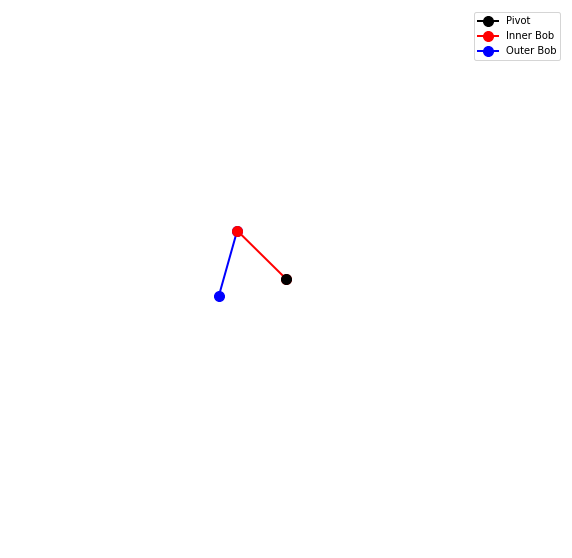

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
axes.set_ylim(-4,4)
axes.set_xlim(-4,4)

line2, = axes.plot([], [], lw = 2, color = 'blue', marker = 'o', markersize = 10)
line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
line0, = axes.plot([0], [0], lw = 2, color = 'black', marker = 'o', markersize = 10)

axes.legend([line0, line1, line2], ['Pivot','Inner Bob', 'Outer Bob'])
axes.set_axis_off()
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,


# animation function
def animate(i):
    # x, y values to be plotted
    line1.set_data([0,x1[i]], [0,y1[i]])
    line2.set_data([x1[i], x2[i]], [y1[i], y2[i]])
        
    return line1, line2,
 
# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 1500,
                            interval = 20,
                            blit = True)
anim.save('pend.mp4', writer = 'ffmpeg', fps = 30)

In [63]:
class Pendulum_with_drag:
    g = 9.81 # gravitational acceleration
    def __init__(self, initial_theta=0, initial_omega=0, time = 10, dt = 0.01, b = 0.1):

        # pendulum equation: theta'' + b * theta' + g/l * sin(theta) = 0
        sol = solve_ivp(lambda t, y : [y[1], -Pendulum_with_drag.g * np.sin(y[0]) - b * y[1]], 
                        [0, time], 
                        [initial_theta, initial_omega], 
                        t_eval=np.arange(0, time, dt))

        self.thetas = sol.y[0]

        self.x = np.sin(self.thetas) # x position
        self.y = -np.cos(self.thetas) # y position

In [64]:
pd = Pendulum_with_drag(initial_theta = np.pi/2, initial_omega = 0, time = 10, dt = 0.01, b = 0.1)

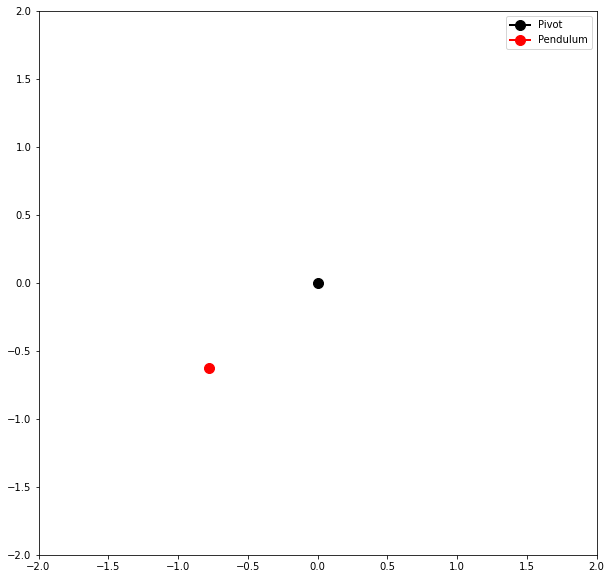

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
 

axes.set_ylim(-2,2)
axes.set_xlim(-2,2)


line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
line0, = axes.plot([0], [0], lw = 2, color = 'black', marker = 'o', markersize = 10)

axes.legend([line0,line1], ['Pivot', 'Pendulum'])

def init():
    line1.set_data([], [])
    return line1, 


# animation function
def animate(i):
    x0, y0 = pd.x[i], pd.y[i]
    # x, y values to be plotted
    line1.set_data(x0, y0)
    return line1,
 
# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 400,
                            interval = 20,
                            blit = True)
anim.save('pend.mp4', writer = 'ffmpeg', fps = 30)

In [111]:
class Perturbable_Pendulum:
    g = 9.81 # gravitational acceleration
    pw = 10000 # pulse width parameter (pm large = small width)
    def __init__(self, initial_theta=0, initial_omega=0, max_time = 10, dt = 0.01, perturbation_rate = 100):
        
        # pendulum equation: theta'' + g/l * sin(theta) = perturbation
        # perturbation is a function of time
        # we will use exp(-t**2) as a Gaussian pulse
        self.time = 0 # initial time
        self.dt = dt # time step
        self.max_time = max_time # maximum time to run simulation for
        
        self.perturbation_rate = perturbation_rate # how many time intervals between pulses. 1 = every time step
        
        self.initial_theta = initial_theta # initial angle
        self.initial_omega = initial_omega # initial angular velocity

        self.thetas, _ = self.solve_pulses(magnitude_vector = [0 if i % 2 == 0 else 0 for i in range(1000)])
        self.xs = np.sin(self.thetas)
        self.ys = -np.cos(self.thetas)

        
        
        
    def nth_pulse(self, t, n, magnitude):
        # the nth pulse equation
        # the time at which the nth pulse happens
        # occurs midway through time step * perturbation_rate
        nth_pulse_time = (2 * n + 1) * self.perturbation_rate * self.dt / 2
        return magnitude * np.exp(-Perturbable_Pendulum.pw * (t - nth_pulse_time)**2)
    
    def nth_state_space(self, t, y, magnitude, n):
        return [y[1], -Perturbable_Pendulum.g * np.sin(y[0]) + self.nth_pulse(t, n, magnitude)]
    
    def solve_nth_pulse(self, magnitude, n, initial_theta, initial_omega):
        # solve the nth pulse
        start_time = n * self.dt * self.perturbation_rate
        end_time = start_time + self.dt * self.perturbation_rate
        return solve_ivp(lambda t, y : self.nth_state_space(t, y, magnitude, n), 
                    [start_time, end_time],
                    [initial_theta, initial_omega], 
                    t_eval=np.arange(start_time, end_time, self.dt))
    
    def solve_pulses(self, magnitude_vector):

        n = 0
        theta = self.initial_theta
        omega = self.initial_omega
        thetas = np.array([theta])
        omegas = np.array([omega])
        
        while self.time < self.max_time:
            nth_pulse = self.solve_nth_pulse(magnitude_vector[n], n, theta, omega)
            thetas = np.append(np.append(thetas[:-1],(thetas[-1]+nth_pulse.y[0][0])/2), nth_pulse.y[0])
            omegas = np.append(np.append(omegas[:-1],(omegas[-1]+nth_pulse.y[1][0])/2), nth_pulse.y[1])
            theta = nth_pulse.y[0][-1]
            omega = nth_pulse.y[1][-1]
            n += 1
            self.time += self.dt * self.perturbation_rate
            
        return thetas, omegas

In [136]:
class Perturbable_Pendulum_v2:
    g = 9.81 # gravitational acceleration
    pw = 10000 # pulse width parameter (pm large = small width)
    def __init__(self, initial_theta=0, initial_omega=0, max_time = 10, dt = 0.01, perturbation_rate = 10, magnitude_vector = [0 for i in range(1000)]):
        
        # pendulum equation: theta'' + g/l * sin(theta) = perturbation
        # perturbation is a function of time
        # we will use exp(-t**2) as a Gaussian pulse
        # perturbation is a sum of pulses of the form beta_i * exp(-pw * (t - t_n)**2)
        self.time = 0 # initial time
        self.dt = dt # time step
        self.max_time = max_time # maximum time to run simulation for
        
        self.perturbation_rate = perturbation_rate # how many time intervals between pulses. 1 = every time step
        
        self.initial_theta = initial_theta # initial angle
        self.initial_omega = initial_omega # initial angular velocity

        self.thetas = self.solve_pulses(magnitude_vector).y[0]
        self.xs = np.sin(self.thetas)
        self.ys = -np.cos(self.thetas)

        
        
        
    def nth_pulse(self, t, n, magnitude):
        # the nth pulse equation
        # the time at which the nth pulse happens
        # occurs midway through time step * perturbation_rate
        nth_pulse_time = (2 * n + 1) * self.perturbation_rate * self.dt / 2
        return magnitude * np.exp(-Perturbable_Pendulum_v2.pw * (t - nth_pulse_time)**2)
    
    def pulse_sum(self, t, magnitude_vector):
        # the sum of all pulses up to time t
        return sum([self.nth_pulse(t, n, magnitude_vector[n]) for n in range(len(magnitude_vector))])
    
    def state_space(self, t, y, magnitude_vector):
        return [y[1], -Perturbable_Pendulum_v2.g * np.sin(y[0]) + self.pulse_sum(t, magnitude_vector)]
    
    def solve_pulses(self, magnitude_vector):
        # solve the nth pulse
        return solve_ivp(lambda t, y : self.state_space(t, y, magnitude_vector), 
                    [0, self.max_time],
                    [self.initial_theta, self.initial_omega], 
                    t_eval=np.arange(0, self.max_time, self.dt))
    
    def error(self): 
        # error function: we want to have theta = pi
        # equivalently, we want cos(theta) + 1 = 0
        return np.sum(np.abs(np.cos(self.thetas) + 1)) / len(self.thetas)


In [ ]:
# keep pendulum upright


In [137]:
pp = Perturbable_Pendulum_v2(initial_theta = np.pi/3, initial_omega = 0, max_time = 10, dt = 0.01, perturbation_rate = 50)

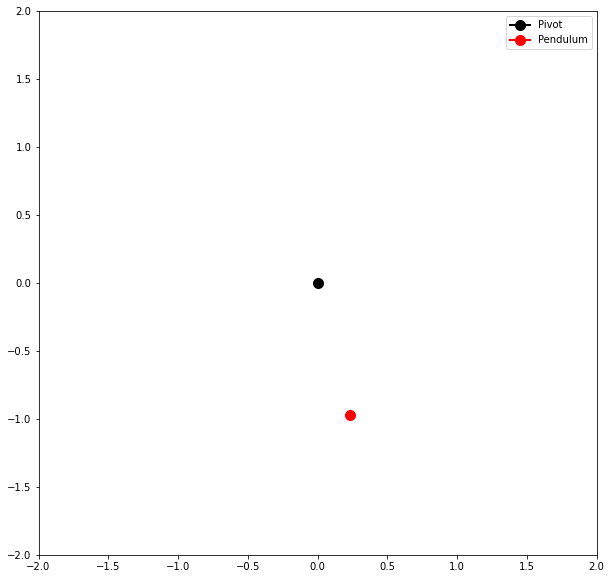

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
 

axes.set_ylim(-2,2)
axes.set_xlim(-2,2)


line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
line0, = axes.plot([0], [0], lw = 2, color = 'black', marker = 'o', markersize = 10)

axes.legend([line0,line1], ['Pivot', 'Pendulum'])

def init():
    line1.set_data([], [])
    return line1, 


# animation function
def animate(i):
    x0, y0 = pp.xs[i], pp.ys[i]
    # x, y values to be plotted
    line1.set_data(x0, y0)
    return line1,
 
# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 800,
                            interval = 20,
                            blit = True)
anim.save('pend.mp4', writer = 'ffmpeg', fps = 30)